In [9]:
import multiprocessing as mp
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as ort
import pandas as pd
from pyDOE import lhs
from scipy.optimize import minimize

if not sys.warnoptions:
    import warnings

    warnings.simplefilter("ignore")



In [10]:
f_model = "../models/最终.onnx"
sess = ort.InferenceSession(f_model)
f_scaler = "../models/最终_minMax.pkl"
with open(f_scaler, "rb") as f:
    input_scaler, output_scaler = pickle.load(f)


def ortRun(x_in):
    # x_in = input_scaler.transform(x_in)
    results = sess.run([], {"rescaling_input": x_in.astype(np.float32)})
    return output_scaler.inverse_transform(results[0])


def convergence_plot(x, y, fname):
    plt.figure()
    plt.plot(x, y, "k")
    plt.plot(x, y, "ko")
    plt.title("Convergence plot")
    plt.xlabel("Number of calls n")
    plt.ylabel("min f(x) after n calls")
    # plt.xscale('log')
    plt.grid()
    plt.savefig(f"../output/{fname}.jpg")


def writeOpt(opt_v, fname):
    opt_x = opt_v[["A1", "A23", "A23", "A4"]].values.reshape(1, -1)
    # display(opt_x)
    np.savetxt(f"../output/inputACT_abbc_{fname}.csv", opt_x, delimiter=",")
    print(f"input for optimal solution is {opt_x}")
    print(f"optimal solution is {opt_v['pred']}")
    return


def sqp_post(sols, fname):
    data = np.asarray(
        [
            np.hstack(
                (
                    sol.success,
                    sol.nfev,
                    sol.x.round(3),
                    ortRun(sol.x.round(3).reshape(1, -1))[0],
                    -sol.fun,
                )
            ).tolist()
            for sol in sols
        ]
    )
    df_opt_sqp = pd.DataFrame(
        data, columns=["success", "nfev", "A1", "A23", "A4", "31", "23y", "23z", "opt"]
    )
    df_opt_sqp["method"] = "sqp"
    x = [
        df_opt_sqp[df_opt_sqp.success == True].nfev[: i + 1].sum()
        for i in range(df_opt_sqp[df_opt_sqp.success == True].shape[0])
    ]
    y = [
        df_opt_sqp[df_opt_sqp.success == True].opt[: i + 1].max()
        for i in range(df_opt_sqp[df_opt_sqp.success == True].shape[0])
    ]
    np.savetxt(f"../output/sqp_{fname}.csv", np.vstack([x, y]), delimiter=",")
    convergence_plot(x, y, "sqp_" + fname)
    return df_opt_sqp


def obj_z_ort(x):
    x = np.asarray(x).reshape(1, -1)
    return -ortRun(x)[0, 2]


def obj_y_ort(x):
    x = np.asarray(x).reshape(1, -1)
    out = ortRun(x)
    return -abs(out[0, 1])


def obj_zy_ort(x):
    x = np.asarray(x).reshape(1, -1)
    out = ortRun(x)
    return -abs(out[0, 2]) / (abs(out[0, 1]) + abs(out[0, 2]))


def sqp(func_obj, x_ini):
    sol = minimize(
        func_obj,
        x_ini,
        bounds=((0.01, 0.3),) * 3,
        method="SLSQP",
        # method="L-BFGS-B",
        options={"disp": False, "maxiter": 200},
    )

    return sol


def sqp_contrained(func_obj, x_ini):
    cons = [
        {
            "type": "ineq",
            "fun": lambda x: 1 - abs(ortRun(np.asarray(x).reshape(1, -1))[0, 1]),
        },
        {
            "type": "ineq",
            "fun": lambda x: ortRun(np.asarray(x).reshape(1, -1))[0, 0] - 0,
        },
    ]

    sol = minimize(
        func_obj,
        x_ini,
        bounds=((0.01, 0.3),) * 3,
        constraints=cons,
        method="SLSQP",
        # method="L-BFGS-B",
        options={"disp": False, "maxiter": 200},
    )

    return sol


## 1. z max with no constraint
We begin with finding the maximum of the displacement in z without any contraint. 

optimized actuations = [0.3   0.3   0.078]


success           1.0
nfev             40.0
A1                0.3
A23               0.3
A4              0.078
31         -10.230202
23y         16.624916
23z        148.654877
opt        148.657776
method            sqp
pred       148.654877
Name: 382, dtype: object

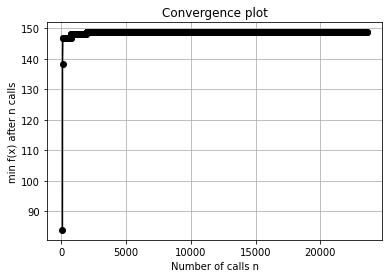

In [11]:
lb = np.array([0.01] * 3)
ub = np.array([0.3] * 3)

n_trials = 1000
trials = lb + (ub - lb) * lhs(3, n_trials).round(3)


def test(x_ini):
    return sqp(obj_z_ort, x_ini)


sols = []
with mp.Pool() as p:
    sols = p.map(test, trials)

df_opt_sqp = sqp_post(sols, "zyratio")
df_opt_sqp["pred"] = df_opt_sqp["23z"]

opt_v = df_opt_sqp.iloc[
    df_opt_sqp[df_opt_sqp.success == True]
    .sort_values(by=["pred"], ascending=False)
    .head(10)["23z"]
    .idxmax()
]
print(
    f'optimized actuations = {opt_v[["A1", "A23", "A4"]].values.astype(np.float32).round(3)}'
)
display(opt_v)
# opt_v.to_csv("output/sqp_zyratio_nn.csv")
# writeOpt(opt_v, "sqp_zyratio")



In [12]:
df_opt_sqp.sort_values("23z", ascending=False)

,success,nfev,A1,A23,A4,31,23y,23z,opt,method,pred
382,1.0,40.0,0.300,0.300,0.078,-10.230202,16.624916,148.654877,148.657776,sqp,148.654877
574,1.0,22.0,0.300,0.300,0.083,-7.503865,15.848478,148.641754,148.639816,sqp,148.641754
830,1.0,40.0,0.300,0.300,0.083,-7.503865,15.848478,148.641754,148.629990,sqp,148.641754
623,1.0,17.0,0.300,0.300,0.085,-6.409416,15.540349,148.631012,148.631744,sqp,148.631012
88,1.0,22.0,0.300,0.300,0.086,-5.862350,15.386288,148.625687,148.624619,sqp,148.625687
...,...,...,...,...,...,...,...,...,...,...,...
946,1.0,15.0,0.059,0.101,0.026,-123.346916,-23.557796,39.412548,39.450733,sqp,39.412548
384,1.0,4.0,0.082,0.021,0.269,555.745544,-64.102753,38.209904,38.184505,sqp,38.209904
175,1.0,4.0,0.144,0.013,0.243,632.125061,-55.697121,35.874020,35.898102,sqp,35.874020
896,0.0,18.0,0.120,0.048,0.077,180.348038,-24.275112,33.487404,33.619511,sqp,33.487404


In [14]:
ortRun(np.asarray([0.3, 0.3, 0.078]).reshape(1, -1).astype(np.float32))

array([[-10.230202,  16.624916, 148.65488 ]], dtype=float32)

## 2. z/y ratio with no constraint

optimized actuations = [0.201 0.281 0.013]


success           1.0
nfev             49.0
A1              0.201
A23             0.281
A4              0.013
31        -226.789062
23y          0.002736
23z        128.417755
opt          0.999956
method            sqp
pred         0.999979
Name: 758, dtype: object

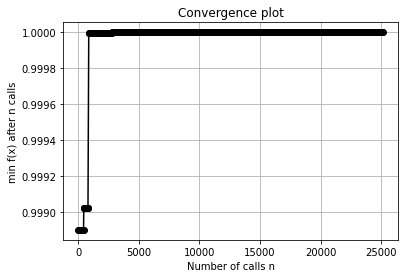

In [33]:
lb = np.array([0.01] * 3)
ub = np.array([0.3] * 3)

n_trials = 1000
trials = lb + (ub - lb) * lhs(3, n_trials).round(3)


def test(x_ini):
    return sqp(obj_zy_ort, x_ini)


sols = []
with mp.Pool() as p:
    sols = p.map(test, trials)

df_opt_sqp = sqp_post(sols, "zyratio")
df_opt_sqp["pred"] = abs(df_opt_sqp["23z"])/((abs(df_opt_sqp["23y"]))+abs(df_opt_sqp["23z"]))

opt_v = df_opt_sqp.iloc[
    df_opt_sqp[df_opt_sqp.success == True]
    .sort_values(by=["pred"], ascending=False)
    .head(10)["23z"]
    .idxmax()
]
print(
    f'optimized actuations = {opt_v[["A1", "A23", "A4"]].values.astype(np.float32).round(3)}'
)
display(opt_v)
# opt_v.to_csv("output/sqp_zyratio_nn.csv")
# writeOpt(opt_v, "sqp_zyratio")


In [23]:
df_opt_sqp.sort_values("pred", ascending=False)


,success,nfev,A1,A23,A4,31,23y,23z,opt,method,pred
541,1.0,8.0,0.300,0.265,0.149,134.825348,0.001729,138.792511,0.999375,sqp,0.999988
743,1.0,25.0,0.300,0.287,0.165,102.797890,-0.007820,144.731644,0.999412,sqp,0.999946
600,1.0,25.0,0.300,0.287,0.165,102.797890,-0.007820,144.731644,0.999412,sqp,0.999946
504,1.0,25.0,0.271,0.205,0.065,102.497169,-0.006423,117.504234,0.999991,sqp,0.999945
450,1.0,47.0,0.283,0.242,0.109,92.760712,-0.009750,132.186310,1.000000,sqp,0.999926
...,...,...,...,...,...,...,...,...,...,...,...
682,1.0,61.0,0.099,0.069,0.300,515.833923,-74.336426,59.327602,0.443527,sqp,0.443856
901,1.0,4.0,0.173,0.022,0.245,663.376770,-55.711277,42.790524,0.434554,sqp,0.434414
976,1.0,15.0,0.151,0.029,0.291,691.508972,-65.905853,48.302593,0.422560,sqp,0.422934
344,1.0,43.0,0.052,0.041,0.262,445.164307,-67.660019,43.051281,0.388913,sqp,0.388861


## 3. z/y ratio with constraints

optimized actuations = [0.292 0.295 0.16 ]


success           1.0
nfev             34.0
A1              0.292
A23             0.295
A4               0.16
31          55.212612
23y         -0.010133
23z        146.032181
opt          0.999646
method            sqp
pred         0.999931
Name: 734, dtype: object

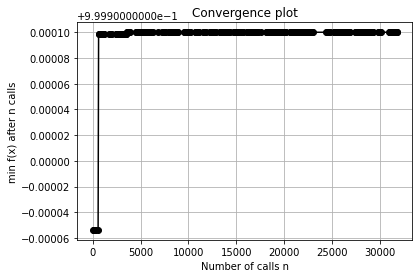

In [24]:
lb = np.array([0.01] * 3)
ub = np.array([0.3] * 3)

n_trials = 1000
trials = lb + (ub - lb) * lhs(3, n_trials).round(3)


def test(x_ini):
    return sqp_contrained(obj_zy_ort, x_ini)


sols = []
with mp.Pool() as p:
    sols = p.map(test, trials)

df_opt_sqp = sqp_post(sols, "zyratio")
df_opt_sqp["pred"] = abs(df_opt_sqp["23z"])/((abs(df_opt_sqp["23y"]))+abs(df_opt_sqp["23z"]))

opt_v = df_opt_sqp.iloc[
    df_opt_sqp[df_opt_sqp.success == True]
    .sort_values(by=["pred"], ascending=False)
    .head(10)["23z"]
    .idxmax()
]
print(
    f'optimized actuations = {opt_v[["A1", "A23", "A4"]].values.astype(np.float32).round(3)}'
)
display(opt_v)
# opt_v.to_csv("output/sqp_zyratio_nn.csv")
# writeOpt(opt_v, "sqp_zyratio")

In [25]:
df_opt_sqp.sort_values("pred", ascending=False)

,success,nfev,A1,A23,A4,31,23y,23z,opt,method,pred
976,1.0,73.0,0.282,0.263,0.124,56.973923,-0.002695,137.449524,0.999932,sqp,0.999980
258,1.0,56.0,0.280,0.294,0.143,1.061040,-0.005319,145.588593,0.999198,sqp,0.999963
239,1.0,171.0,0.278,0.094,0.025,348.929291,-0.002805,76.155632,0.999423,sqp,0.999963
766,1.0,35.0,0.296,0.208,0.101,200.459076,-0.005105,122.949776,0.999972,sqp,0.999958
300,1.0,38.0,0.300,0.182,0.088,259.780884,-0.004747,114.064728,0.999920,sqp,0.999958
...,...,...,...,...,...,...,...,...,...,...,...
783,0.0,106.0,0.016,0.010,0.300,560.747009,-71.908638,36.858425,0.338816,sqp,0.338875
762,0.0,636.0,0.010,0.010,0.292,537.727844,-70.529259,35.733669,0.336218,sqp,0.336276
27,0.0,124.0,0.010,0.010,0.281,515.611389,-68.217102,34.312450,0.334592,sqp,0.334659
896,0.0,36.0,0.010,0.010,0.278,509.579681,-67.586525,33.924847,0.334236,sqp,0.334198


## 4. z max with constraints

optimized actuations = [0.3   0.3   0.173]


success           1.0
nfev             26.0
A1                0.3
A23               0.3
A4              0.173
31          83.714066
23y           0.05726
23z        146.921844
opt        146.937073
method            sqp
pred          0.99961
Name: 348, dtype: object

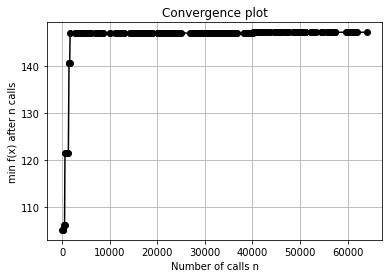

In [28]:
lb = np.array([0.01] * 3)
ub = np.array([0.3] * 3)

n_trials = 1000
trials = lb + (ub - lb) * lhs(3, n_trials).round(3)


def test(x_ini):
    return sqp_contrained(obj_z_ort, x_ini)


sols = []
with mp.Pool() as p:
    sols = p.map(test, trials)

df_opt_sqp = sqp_post(sols, "zyratio")
df_opt_sqp["pred"] = abs(df_opt_sqp["23z"])/((abs(df_opt_sqp["23y"]))+abs(df_opt_sqp["23z"]))

opt_v = df_opt_sqp.iloc[
    df_opt_sqp[df_opt_sqp.success == True]
    .sort_values(by=["pred"], ascending=False)
    .head(10)["23z"]
    .idxmax()
]
print(
    f'optimized actuations = {opt_v[["A1", "A23", "A4"]].values.astype(np.float32).round(3)}'
)
display(opt_v)

In [29]:
df_opt_sqp.sort_values("pred", ascending=False)


,success,nfev,A1,A23,A4,31,23y,23z,opt,method,pred
445,0.0,36.0,0.193,0.300,0.011,-266.287994,-0.012400,132.781586,132.756958,sqp,0.999907
296,1.0,28.0,0.300,0.215,0.112,206.075928,-0.020982,125.960243,125.915512,sqp,0.999833
430,1.0,80.0,0.258,0.054,0.011,385.414124,-0.009802,57.443592,57.329098,sqp,0.999829
683,1.0,105.0,0.276,0.222,0.084,94.841225,-0.033020,124.831718,124.817146,sqp,0.999736
232,1.0,161.0,0.289,0.292,0.154,45.598835,0.047516,145.545441,145.633743,sqp,0.999674
...,...,...,...,...,...,...,...,...,...,...,...
861,0.0,976.0,0.023,0.010,0.299,566.823303,-71.315948,36.878788,36.813717,sqp,0.340856
510,0.0,74.0,0.025,0.012,0.272,509.539429,-66.073326,34.008675,33.981014,sqp,0.339808
333,0.0,124.0,0.010,0.010,0.283,519.632446,-68.637505,34.570854,34.572655,sqp,0.334962
51,0.0,22.0,0.010,0.010,0.263,479.421112,-64.433601,31.986853,32.048588,sqp,0.331743
